# Please read this conjunction with my post on medium

https://medium.com/@singhsa3/spark-in-action-to-predict-customer-churn-rate-on-a-real-dataset-75ffabb1332c

In [127]:
import time
start_time = time.time()

In [211]:
# import libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import lit
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Creating spark sessions and load data from S3

In [129]:
# create a Spark session
spark = SparkSession \
.builder \
.appName("capstone") \
.getOrCreate()

In [130]:
# Load data
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
#event_data="s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
event_data = "sparkify_event_data.json"
#event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis

## Data preprocessing

In [131]:
# Filtering blank user ids and session ids
df=df.filter((df.userId != '') | (df.sessionId !=''))

In [132]:
# Feature engineering
# Here we are converting some values to numbers

# Define the window
user_window = Window \
    .partitionBy("userId") \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

# A function to convert into boolean 0 or 1
bool_conv = F.udf(lambda ishome , chk_val : int(ishome == chk_val), IntegerType())

# Converting Male to 1 everyone else to 0
df= df.withColumn("mf",bool_conv (F.column('gender'),lit("M"))).na.fill(0)

# Converting paid to 1 and everyone else to 0
df= df.withColumn("lvl", bool_conv(F.col('level'),lit("paid"))).na.fill(0)

# Converting Home page visit to 1 and everyone else to 0
df= df.withColumn('homevisit', bool_conv(F.col('page'),lit("Home"))).na.fill(0)

# Visit to home each time is considered a visit. The visits are numbered

df= df.withColumn('period', F.sum('homevisit').over(user_window))

# This will be used to determine how many songs played in a visit.
cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) 

period_count=cusum.filter((cusum.page == 'NextSong') ) \
    .groupBy('userId', 'period') \
    .agg({'period':'count'}) 


In [133]:
# Possible values in a page visit
df.select('page').distinct().show(30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [134]:
# We are building some additional features
# avg number of songs listened per visit
avg_songs =period_count.groupby('userId').agg(F.round(F.avg('count(period)'),scale=0).alias("avg_songs"))
# What was the last reported level (paid or free)
last_level  = cusum.filter((cusum.page == 'NextSong') ).groupby('userId').agg(F.first("lvl").alias('last_level'))
# what was the last reported gender
last_gender = cusum.filter((cusum.page == 'NextSong') ).groupby('userId').agg(F.first("mf").alias('last_gender'))
# Irrespective of visits , here we will count total number of times visited on each page
page_agg =df.select("userId","page").groupby("userId", "page").agg(F.count("page").alias("page_count"))
# We are pivoting such that each page appear of on the column.
# It is akin to one hot encoding, except that the values are not 0 or 1 but actual number of visits.
page_agg =page_agg.groupby("userId").pivot("page").sum("page_count")

In [135]:
# Here we will create a base dataset for feeding into ML algorithm
df_base =page_agg.join(avg_songs, (avg_songs.userId ==  page_agg.userId), how="left" ).drop(avg_songs.userId)
df_base = df_base.join(last_level,(last_level.userId == df_base.userId),  how ="left").drop(last_level.userId)
df_base = df_base.join(last_gender,(last_gender.userId == df_base.userId),  how ="left").drop(last_gender.userId)
df_base=df_base.na.fill(0)

In [136]:
# Churn is based on cacellation confirmation. PS: I am using Label for churns
bool_conv2 = F.udf(lambda ishome  : 0 if ishome == 0 else 1)
df_base= df_base.withColumn('label',bool_conv2 (F.col( 'Cancellation Confirmation'))*1.0)


In [137]:
# droping some columns that are not neeeded
df_base=df_base.drop('Cancel','Cancellation Confirmation')

In [138]:
# Renaming columns so that the column names."_" was creating some problems.
for i,x in enumerate(df_base.columns):
    y = df_base.columns[i].replace(" ", "_")  
    df_base= df_base.withColumnRenamed(x,y)   
    

In [139]:
# Our base dataset is now ready
df_base.dtypes

[('About', 'bigint'),
 ('Add_Friend', 'bigint'),
 ('Add_to_Playlist', 'bigint'),
 ('Downgrade', 'bigint'),
 ('Error', 'bigint'),
 ('Help', 'bigint'),
 ('Home', 'bigint'),
 ('Login', 'bigint'),
 ('Logout', 'bigint'),
 ('NextSong', 'bigint'),
 ('Register', 'bigint'),
 ('Roll_Advert', 'bigint'),
 ('Save_Settings', 'bigint'),
 ('Settings', 'bigint'),
 ('Submit_Downgrade', 'bigint'),
 ('Submit_Registration', 'bigint'),
 ('Submit_Upgrade', 'bigint'),
 ('Thumbs_Down', 'bigint'),
 ('Thumbs_Up', 'bigint'),
 ('Upgrade', 'bigint'),
 ('userId', 'string'),
 ('avg_songs', 'double'),
 ('last_level', 'int'),
 ('last_gender', 'int'),
 ('label', 'double')]

In [140]:
# This is needed to speed up toPandas() and avoid any errors
spark.conf.set("spark.sql.execution.arrow.enabled", "true")


In [141]:
df_base_pandas = df_base.toPandas()

/root/anaconda3/lib/python3.7/site-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [142]:
# Producing general statistics for each column
df_base_pandas.describe()

,About,Add_Friend,Add_to_Playlist,Downgrade,Error,Help,Home,Login,Logout,NextSong,...,Submit_Downgrade,Submit_Registration,Submit_Upgrade,Thumbs_Down,Thumbs_Up,Upgrade,avg_songs,last_level,last_gender,label
count,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,...,22278.000000,22278.00000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000,22278.000000
mean,4.163704,17.131879,26.839079,8.270042,1.165365,6.962025,60.288266,13.302361,13.286875,935.913098,...,0.291498,0.01800,0.679370,10.737589,51.686193,2.267125,21.537571,0.226681,0.522489,0.224571
std,297.350418,20.514932,32.071278,11.600283,6.338093,171.973041,2746.874171,1985.486012,14.549335,1099.625399,...,0.605855,2.68662,0.756197,12.615942,64.588850,2.652989,6.994660,0.418694,0.499505,0.417309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,5.000000,0.000000,0.000000,1.000000,11.000000,0.000000,4.000000,204.000000,...,0.000000,0.00000,0.000000,2.000000,10.000000,0.000000,17.000000,0.000000,0.000000,0.000000
50%,1.000000,10.000000,16.000000,4.000000,1.000000,3.000000,27.000000,0.000000,9.000000,552.000000,...,0.000000,0.00000,1.000000,7.000000,29.000000,1.000000,22.000000,0.000000,1.000000,0.000000
75%,3.000000,23.000000,36.000000,12.000000,2.000000,8.000000,55.000000,0.000000,18.000000,1259.000000,...,0.000000,0.00000,1.000000,15.000000,68.000000,3.000000,25.000000,0.000000,1.000000,0.000000
max,44382.000000,222.000000,340.000000,133.000000,914.000000,25652.000000,409978.000000,296350.000000,168.000000,11314.000000,...,7.000000,401.00000,8.000000,154.000000,836.000000,29.000000,135.000000,1.000000,1.000000,1.000000


## Data Visualization 

In [143]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


In [144]:
# Spark temp view for running SQL
df.createOrReplaceTempView("dfsql")
df_base.createOrReplaceTempView("dfbasesql")

/root/anaconda3/lib/python3.7/site-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Text(0.5, 1.0, 'Cancellation vs total')

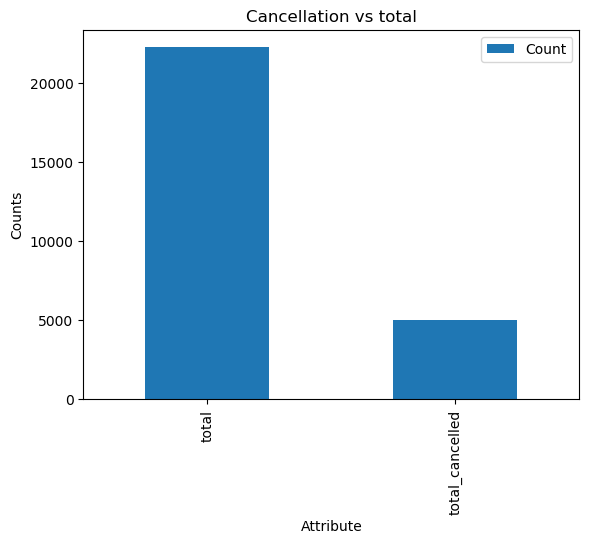

In [145]:
# 1. How many cancelled in the total population
my_data = spark.sql("SELECT count(*) as total, sum(label) as total_cancelled FROM dfbasesql")
pdf1=my_data.toPandas()
pdf1=pdf1.transpose().reset_index()
pdf1.plot(kind='bar',x='index',y=0, label='Count')
plt.xlabel('Attribute')
plt.ylabel('Counts')
plt.title('Cancellation vs total')


Text(0.5, 1.0, 'males vs females')

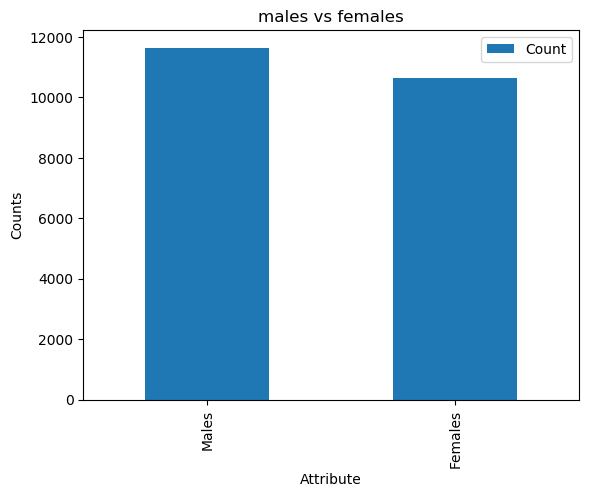

In [146]:
# 2. How many males and females are in the total population?
my_data=spark.sql("SELECT sum(CASE WHEN last_gender=1 THEN 1 ELSE 0 END) as Males, sum(CASE WHEN last_gender=0 THEN 1 ELSE 0 END) as Females FROM dfbasesql")
pdf1=my_data.toPandas()
pdf1=pdf1.transpose().reset_index()
pdf1.plot(kind='bar',x='index',y=0, label='Count')
plt.xlabel('Attribute')
plt.ylabel('Counts')
plt.title('males vs females')


Text(0.5, 1.0, 'Top N locations by number of users ')

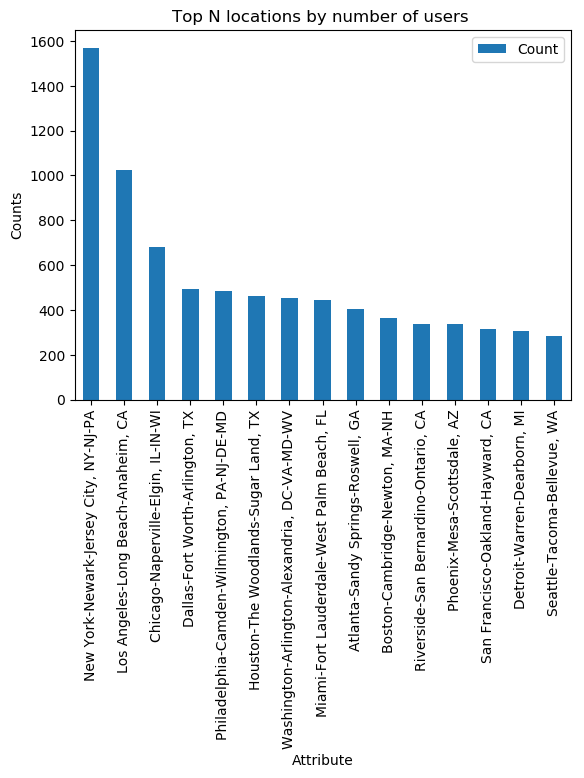

In [147]:
# 3. What are the Popular locations ?
my_data = spark.sql("SELECT location, count(*) as nbr_of_users from (SELECT distinct userId, location FROM dfsql) a group by location order by 2 desc limit 15")
pdf1=my_data.toPandas()
#pdf1=pdf1.transpose().reset_index()
pdf1.plot(kind='bar',x='location',y='nbr_of_users', label='Count')
plt.xlabel('Attribute')
plt.ylabel('Counts')
plt.title('Top N locations by number of users ')

Text(0.5, 1.0, 'Top N locations by number of users who cancelled')

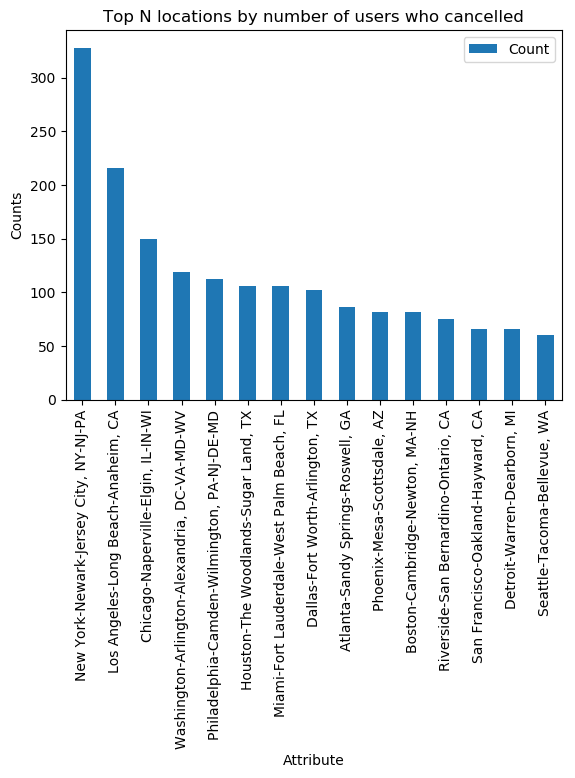

In [148]:
# 4. Which location most cancellation are coming from 
my_data = spark.sql("SELECT location, count(*) as nbr_of_users from (SELECT distinct userId, location FROM dfsql where page ='Cancellation Confirmation') a group by   location order by 2 desc Limit 15")
pdf1=my_data.toPandas()
#pdf1=pdf1.transpose().reset_index()
pdf1.plot(kind='bar',x='location',y='nbr_of_users', label='Count')
plt.xlabel('Attribute')
plt.ylabel('Counts')
plt.title('Top N locations by number of users who cancelled')

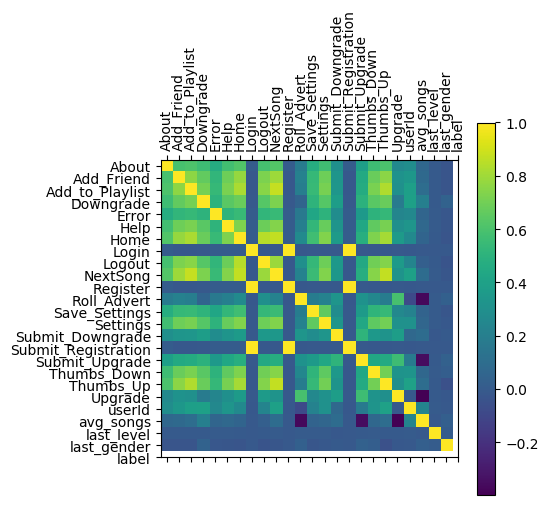

In [149]:
plotdf =df_base_pandas
plt.matshow(plotdf.corr('kendall'))
plt.xticks(range(len(plotdf.columns)), plotdf.columns,rotation='vertical')
plt.yticks(range(len(plotdf.columns)), plotdf.columns)
plt.colorbar()
plt.show()

# Methodology 

In [150]:
# Function to get number of negative cases. This will be used to underweight -ve and overweight +ve
def cancelPCT(train):
    dataset_size=float(train.select("label").count())
    numPositives=train.select("label").where('label == 1').count()
    per_ones=(float(numPositives)/float(dataset_size))*100
    numNegatives=float(dataset_size-numPositives)
    print('The number of ones are {}'.format(numPositives))
    print('Percentage of ones are {}'.format(per_ones))
    return dataset_size, numNegatives

In [151]:
cancelPCT(df_base)

The number of ones are 5003
Percentage of ones are 22.457132597181076


(22278.0, 17275.0)

In [152]:
# we will now further prepare dataset of ML
continuousCols=df_base.columns
continuousCols.remove("label")
continuousCols.remove("userId")

continuousCols

['About',
 'Add_Friend',
 'Add_to_Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Login',
 'Logout',
 'NextSong',
 'Register',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Registration',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade',
 'avg_songs',
 'last_level',
 'last_gender']

In [153]:
# splitting data
train, test =df_base.randomSplit([0.8, 0.2], seed=42)

In [154]:
# Let us check how is the "cancelled " distribution in our training set
dataset_size, numNegatives = cancelPCT(train)

The number of ones are 4010
Percentage of ones are 22.573744652105383


In [155]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7742625534789462


In [156]:
train=train.withColumn("classWeights", F.when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.22573744652105376|
|0.22573744652105376|
| 0.7742625534789462|
| 0.7742625534789462|
|0.22573744652105376|
+-------------------+
only showing top 5 rows



In [157]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# ps: all my features are continuous (i.e. no categorical) and hence no need for Vector Index
assembler = VectorAssembler(inputCols=continuousCols, outputCol="features")

from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
lr = LogisticRegression(labelCol="label", featuresCol="Scaled_features",weightCol="classWeights",maxIter=10)

pipeline = Pipeline(stages=[assembler,standardscaler,lr])

In [158]:
model = pipeline.fit(train)

# Results

In [159]:
results=model.transform(test)

### Performance Evaluations

In [160]:
results_pandas=results.toPandas()

/root/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [173]:
# Generic function to create various performance metrics
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)

def eval_metrics(y_test, y_pred):
    # True Prositive, False Positive, True Negative and False Negative
    TP,FP, TN, FN = perf_measure(y_test, y_pred)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False ommision rate
    FOR = FN/(TN+FN)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print ('True Positive Rate: ', round(TPR,2))
    print( 'False Ommision Rate', round(FOR,2))
    print( 'Precision :' , round(PPV,2))
    print('accuracy :', round(ACC,2))
    return TPR,FOR,ACC


In [174]:
y_test = results_pandas['label']
y_pred = results_pandas['prediction']
TPR,FOR,ACC = eval_metrics(y_test, y_pred)

True Positive Rate:  0.63
False Ommision Rate 0.14
Precision : 0.32
accuracy : 0.63


## Coefficients

In [163]:
glr = model.stages[2]

In [164]:
pd.DataFrame(continuousCols,glr.coefficients).reset_index().sort_values(by='index', ascending=False)

,index,0
3,0.762967,Downgrade
16,0.600274,Submit_Upgrade
11,0.571272,Roll_Advert
21,0.323290,last_level
17,0.279375,Thumbs_Down
13,0.149809,Settings
22,-0.004568,last_gender
7,-0.055369,Login
10,-0.055369,Register
15,-0.055369,Submit_Registration


# Fine Tuning

## Method 1 : Using Decision Tree

In [165]:
from pyspark.ml.classification import DecisionTreeClassifier
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="label", featuresCol="Scaled_features")
# Chain indexers and tree in a Pipeline
pipelineD = Pipeline(stages=[assembler,standardscaler,dt])
model2 = pipelineD.fit(train)
results2=model2.transform(test)
results_pandas2=results2.toPandas()

/root/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [175]:
print("Method 1 : Decision Tree")
y_test = results_pandas2['label']
y_pred = results_pandas2['prediction']
TPR,FOR,ACC = eval_metrics(y_test, y_pred)

Method 1 : Decision Tree
True Positive Rate:  0.1
False Ommision Rate 0.21
Precision : 0.58
accuracy : 0.79


## Method 2 : Hyper parameter tuning using Spark

In [166]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]).addGrid(lr.maxIter,[10, 100]).addGrid(lr.regParam,[0, 0.5, 2.0]).build()

In [167]:
# Create K-fold CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')
cv = CrossValidator(estimator= pipeline,estimatorParamMaps=paramGrid, evaluator = evaluator, numFolds=3)
# Run cross validations
cvModel = cv.fit(train)
predict_test=cvModel.transform(test)

In [168]:
results3 = predict_test.toPandas()

In [215]:
print("Method 2 : Hyperparameter Tuning")
y_test = results3['label']
y_pred = results3['prediction']
TPR,FOR,ACC = eval_metrics(y_test, y_pred)

Method 2 : Hyperparameter Tuning
True Positive Rate:  0.62
False Ommision Rate 0.14
Precision : 0.32
accuracy : 0.63


## Method 3 : Hyper parameter tuning using Sklearn

### Logistics Regresssion

In [177]:
df_base_pandas.columns

Index(['About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help',
       'Home', 'Login', 'Logout', 'NextSong', 'Register', 'Roll_Advert',
       'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Registration',
       'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'userId',
       'avg_songs', 'last_level', 'last_gender', 'label'],
      dtype='object')

In [178]:
X = df_base_pandas.drop(['userId','label'],  axis=1)
y = df_base_pandas['label']

In [216]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.75, random_state=42)

In [217]:
# This is needed for prediction. We are converting to nupy array
y_test= y_test.values
y_test= y_test.reshape(-1,1)

In [180]:
from sklearn.metrics.scorer import make_scorer, recall_score
scoring = make_scorer(recall_score, average='macro')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression as Lg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
logr = Lg(random_state=0, class_weight='balanced', solver ='saga')


In [183]:
from sklearn.pipeline import Pipeline as Pl
steps = [('a',scaler),('mylogr',logr)]
pipeline = Pl(steps)

param_grid = {'mylogr__penalty' : ['l1', 'l2'],'mylogr__max_iter': [10,100] ,'mylogr__C' : [0.1 ,0.5,2,4] }
gcv= GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=5)

In [184]:
modelL = gcv.fit(X_train, y_train)

/root/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/root/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [221]:
y_pred = modelL.predict(X_test)

TPR,FOR,ACC = eval_metrics(y_test, y_pred.reshape(-1,1))

True Positive Rate:  0.6
False Ommision Rate 0.15
Precision : 0.33
accuracy : 0.64


### Decision Trees

In [195]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(random_state=0, class_weight='balanced')
steps = [('a',scaler),('mydt',dt)]
pipeline = Pl(steps)
param_grid = {'mydt__criterion' : ['gini', 'entropy'],'mydt__max_depth': [2,5,10,20,50,100] , 'mydt__min_samples_leaf': [1, 5, 10, 20, 50, 100] }
gcv= GridSearchCV(estimator= pipeline, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=5)


In [213]:
modelD = gcv.fit(X_train, y_train)

In [218]:
y_pred = modelD.predict(X_test)
TPR,FOR,ACC = eval_metrics(y_test, y_pred.reshape(-1,1))

True Positive Rate:  0.54
False Ommision Rate 0.17
Precision : 0.31
accuracy : 0.63
